# pymc-continuous-kronecker
GP model using pymc on continuous data (week, longitude and latitude of county centroid)

In [41]:
import pandas as pd
import pymc as pm
import numpy as np
from plotnine import *

## Data preprocess
Import chickenpox data and pivot into tabular format with x, y, time, counts

In [42]:
df = pd.read_csv("data/hungary_chickenpox.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y") 
df.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,2005-01-03,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,2005-01-10,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,2005-01-17,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,2005-01-24,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,2005-01-31,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [43]:
df["week"] = df.index
df.drop("Date", axis=1, inplace=True)
df = pd.melt(df, id_vars="week", var_name="na_caps", value_name="cases")
df.head()



,week,na_caps,cases
0,0,BUDAPEST,168
1,1,BUDAPEST,157
2,2,BUDAPEST,96
3,3,BUDAPEST,163
4,4,BUDAPEST,122


In [44]:
centroids = pd.read_csv("data/hungary_county_centroids.csv")
df = df.merge(centroids[["na_caps", "long", "lat"]], on="na_caps", how="left")
df = df[["week", "na_caps", "long", "lat", "cases"]]
df.head()

,week,na_caps,long,lat,cases
0,0,BUDAPEST,19.110875,47.488038,168
1,1,BUDAPEST,19.110875,47.488038,157
2,2,BUDAPEST,19.110875,47.488038,96
3,3,BUDAPEST,19.110875,47.488038,163
4,4,BUDAPEST,19.110875,47.488038,122


/Users/tar15/opt/anaconda3/envs/spatiotemporal/lib/python3.10/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


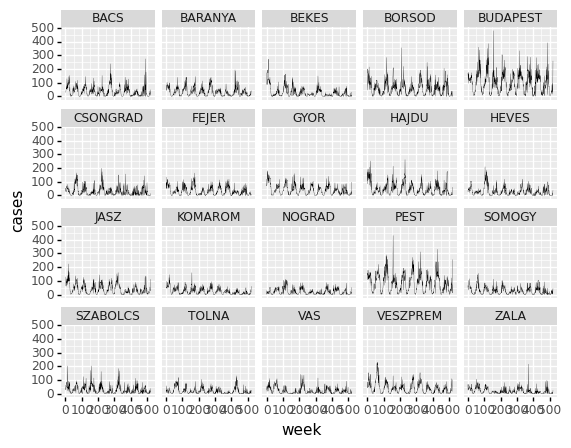

<ggplot: (349000792)>

In [45]:
(ggplot(df, aes(x="week", y="cases"))
+ geom_line(size=0.1)
+ facet_wrap("~na_caps"))

In [46]:
X = df[["long", "lat"]].to_numpy()
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

t = df[["week"]].to_numpy()
t = (t - np.mean(t, axis=0)) / np.std(t, axis=0)

cases = df[["cases"]].to_numpy()

## pymc model

In [47]:
with pm.Model() as model:
    mean = pm.Normal("alpha", sigma=10.0)

    sigma = pm.HalfNormal("sigma", sigma=5.0)
    rho = pm.HalfNormal("rho", sigma=5.0)
    kernel = sigma**2 * pm.gp.cov.Matern52(2, ls=rho)
    
    gp_space = pm.gp.Latent(cov_func=kernel)

    gp_space = gp_space.prior("gp_space", X=X)
    # gp_time = gp_time.prior("gp_time", X=t)
    latent_rate = pm.math.exp(mean + gp_space)

    pm.Poisson("cases", mu=latent_rate, observed=cases)

In [48]:
with model:
    idata = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/tar15/opt/anaconda3/envs/spatiotemporal/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma, rho, gp_space_rotated_]


ValueError: Not enough samples to build a trace.